# Forecasting

In [1]:
import os
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings

missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing', 'missing', 'MISSING', 'Unknown',
                  'Weet ik niet', 'None', 'ONBEKEND', '"ontbrekend"', '"onbekend"', 'onbekend']

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score as r2score


class GeneralRegression:
    def __init__(self, degree=1, exp=False, log=False):
        self.degree = degree
        self.exp = exp
        self.log = log
        self.model = None
        self.x_orig = None
        self.y_orig = None
        self.X = None
        self.y = None

    def fit(self, x: np.array, y: np.array):
        self.x_orig = x
        self.y_orig = y
        self.X = x.reshape(-1, 1)

        if self.exp:
            self.y = np.log(y)

        else:
            self.y = y

        if self.log:
            self.X = np.log(self.X)

        self.model = make_pipeline(PolynomialFeatures(degree=self.degree), LinearRegression())
        self.model.fit(self.X, self.y)

    def predict(self, x: np.array):
        X = x.reshape(-1, 1)

        if self.exp:
            return np.exp(self.model.predict(X))

        if self.log:
            return self.model.predict(np.log(X))

        return self.model.predict(X)

    @property
    def r2_score(self):
        return r2score(self.y_orig, self.predict(self.x_orig))

    @property
    def se_(self):
        if self.exp:
            return mean_squared_error(self.predict(self.X), np.exp(self.y), squared=False)
        if self.log:
            return mean_squared_error(self.predict(self.X), np.log(self.y), squared=False)
        return mean_squared_error(self.predict(self.X), self.y, squared=False)

    @property
    def coef_(self):
        return self.model.steps[1][1].coef_

    @property
    def intercept_(self):
        return self.model.steps[1][1].intercept_

In [3]:
def outlier_boundaries(x, factor=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    I = Q3 - Q1
    return [Q1 - factor * I, Q3 + factor * I]


def drop_outliers(df, row):
    df['Z-Score'] = np.abs((df[row] - df[row].mean()) / df[row].std())
    filtered_df = df[df['Z-Score'] <= 3]
    filtered_df = filtered_df.drop('Z-Score', axis=1)
    return filtered_df


def aantal_klassen(series):
    n = len(series)
    print("Sturges (# klassen): " + str(math.ceil(1 + math.log2(n))))  # Sturges
    b = 3.5 * statistics.stdev(series) / (n ** (1 / 3))
    print("Scott (klasse breedte): " + str(math.ceil((series.max() - series.min()) / b)))  # Scott
    print("Scott (# klassen): " + str(math.ceil(math.sqrt(n))))
    print("[√n]: " + str(math.ceil(math.sqrt(n))))


# Samenhang
def kendall(x, y):
    x = x.rank()
    y = y.rank()
    n = len(x)
    aantal = 0

    for i in range(1, n - 1):
        for j in range(i + 1, n):
            aantal = aantal + np.sign(x[i] - x[j]) * np.sign(y[i] - y[j])

    return 2 * aantal / (n / (n - 1))


def makescatter(x, y):
    plt.scatter(x, y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()


def scatterWhitReg(X, y, se=0):  #model moet aanwezig zijn
    fig, ax = plt.subplots()
    _ = ax.scatter(X, y)
    xx = np.arange(X.min(), X.max(), (X.max() - X.min()) / 100)
    yy = model.predict(xx.reshape(-1, 1))
    _ = ax.fill_between(xx, yy - se, yy + se, color="yellow", alpha=0.2)
    _ = ax.plot(xx, yy, color='red')
    _ = ax.set_xlabel(X.name)
    _ = ax.set_ylabel(y.name)
    plt.show()


def bestmodel(x, y):
    modelD1 = GeneralRegression(degree=1)
    modelD2 = GeneralRegression(degree=2)
    modelD3 = GeneralRegression(degree=3)
    modelL1 = GeneralRegression(degree=1, log=True)
    modelE1 = GeneralRegression(degree=1, exp=True)

    modelD1.fit(x.to_numpy(), y.to_numpy())
    modelD2.fit(x.to_numpy(), y.to_numpy())
    modelD3.fit(x.to_numpy(), y.to_numpy())
    modelL1.fit(x.to_numpy(), y.to_numpy())
    modelE1.fit(x.to_numpy(), y.to_numpy())
    out = pd.Series(data=[modelD1.r2_score, modelD2.r2_score, modelD3.r2_score, modelL1.r2_score, modelE1.r2_score],
                    index=["lineair:", "kwadratisch:", "kubisch:", "logaritmisch", "exponentieel"])
    return out.sort_values(ascending=False)


def autocorrDia(x):
    plt.figure()
    plot_acf(np.array(x).astype(float), lags=len(x) - 1)
    plt.xlabel('offset')
    plt.ylabel('correlatie')
    plt.title(f'Auto-correlatie {x.name}')
    plt.show()


# Forecasting
def smooth(y: np.array, m: int):
    result = np.empty(0)
    for i in range(y.size - m + 1):
        result = np.append(result, [np.mean(y[i:i + m])])

    return result


def find_trend(y: np.array, m: int):
    result = smooth(y, m)
    nan = [np.nan] * int(m / 2)
    if m % 2 == 0:
        result = smooth(result, 2)
        result = np.hstack([nan, result, nan])

    return result


def naive(y: np.array):
    if y.size > 0:
        return y[-1]
    return np.NaN


def plotforecast(original: np.array, voorspeldd: np.array):
    plt.figure()
    plt.plot(range(len(original)), original, "o-", label="gegeven")
    plt.plot(range(len(original), len(original) + len(voorspeld)), voorspeldd, "^-", label="voorspeld")
    plt.show()


def forecast_past(past, forecast_function):
    result = []
    for i in range(len(past)):
        result += [forecast_function(past[:i].to_numpy())]
    return result


def mae(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return errors.abs().mean()


def rmse(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return math.sqrt((errors ** 2).mean())


def mape(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return (errors / past).abs().mean()


def betrw(X: np.array, y):
    return pd.Series(data=[mae(X, y), rmse(X, y), mape(X, y)], index=['mae', 'rmse', 'mape'])


def average(y: np.array):
    if y.size < 1:
        return np.NaN
    return y.mean()


def moving_average_forecasting(m):
    def result(past):
        n = len(past)
        if n < m:
            return math.nan
        return pd.Series(past[-m:]).mean()

    return result


def bereken_gewichten(y: np.array, m: int):
    # n is aantal elementen
    n = y.size
    # we hebben > 2 * m elementen nodig
    if n < 2 * m:
        return np.NaN
    # selecteer de laatste elementen
    M = y[-(m + 1):-1]
    # maak een matrix M van coëfficiënten
    for i in range(1, m):
        M = np.vstack([M, y[-(m + i + 1):-(i + 1)]])

    # selecteer de bekenden
    v = np.flip(y[-m:])
    # los het stelsel van m vergelijkingen op
    return np.linalg.solve(M, v)


def lineair_combination_forecasting(m):
    def result(past):
        n = len(past)
        if n < 2 * m:
            return math.nan
        a = bereken_gewichten(past, m)
        return (past[-m:] * a).sum()

    return result


def create_trend_model(y):
    X = np.arange(0, y.size)
    model = GeneralRegression()
    model.fit(X, y)
    # we geven een voorspellersfunctie terug
    return lambda x: model.predict(np.array(x))
    # return model


def general_regression(x: pd.Series, y: pd.Series, degree=1, exp=False, log=False):
    fun_y = inv_fun_y = lambda x: x
    fun_x = lambda x: x
    if (exp):
        fun_y = np.exp
        inv_fun_y = np.log
    if (log):
        fun_x = np.log
    model = np.polyfit(fun_x(x), inv_fun_y(y), degree)
    line = np.poly1d(model)
    predict = lambda x: fun_y(line(fun_x(x)))
    predicted = predict(x)
    squared_residuals = (predicted - y) ** 2
    variance_y = (y - y.mean()) ** 2
    se = math.sqrt(squared_residuals.mean())
    r2 = 1 - (squared_residuals.sum() / variance_y.sum())
    result = [se, r2, predict] + [model[-i] for i in range(1, len(model) + 1)]
    index = ["se", "r2", "predict"] + [chr(i + 96) for i in range(1, len(model) + 1)]
    return pd.Series(result, index=index)

## Bezoekers in een pretpark
Een pretpark wil kunnen voorspellen hoeveel bezoekers er zullen komen in een bepaalde maand. Daarvoor hebben ze gedurende 4 jaar opgeschreven hoeveel bezoekers er waren, voor iedere maand. Je vindt deze data in “pretpark.csv”.  Deze data is ook direct leesbaar in Python (geen foute of ontbrekende data).

In [4]:
df = pd.read_csv("./data/pretpark.csv", delimiter=";", header=0)

1. Maak een grafiek van de data. Wat merk je visueel op? Stijgt of daalt het aantal bezoekers?
Is er een patroon herkenbaar?

Overal stijging met duidelijke periodes.


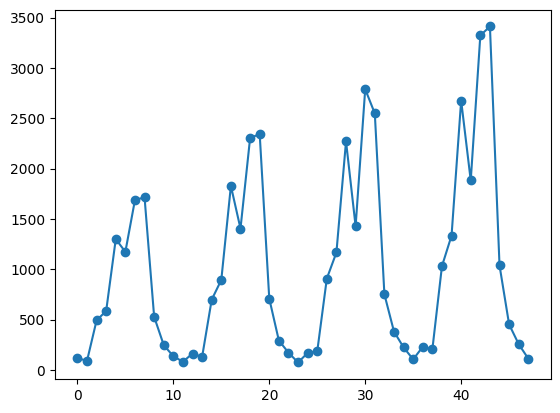

In [6]:
plt.figure()
plt.plot(range(len(df["aantal.bezoekers"])), df["aantal.bezoekers"], 'o-')

print("Overal stijging met duidelijke periodes.")

2. Zou je het additieve of multiplicatieve model gebruiken?

Als er sprake is van een algemene stijging met duidelijke periodes, zou ik het multiplicatieve model gebruiken.

Het multiplicatieve model is geschikt wanneer er sprake is van een patroon waarbij de veranderingen in de tijd proportioneel zijn aan de huidige waarde. Bij een algemene stijging met duidelijke periodes impliceert het multiplicatieve model dat de stijging in elk periode een bepaald percentage is van de waarde in dat periode. Dit percentage kan variëren afhankelijk van de specifieke gegevens en het patroon dat wordt waargenomen.

Daarentegen is het additieve model geschikt wanneer de veranderingen in de tijd onafhankelijk zijn van de huidige waarde. Het additieve model wordt gebruikt wanneer de absolute veranderingen in de tijd belangrijker zijn dan de relatieve veranderingen.

Om het beste model te bepalen, zou ik aanbevelen om een grondige analyse van de gegevens uit te voeren, inclusief het bestuderen van het patroon en de kenmerken van de stijging en periodes. Dit kan helpen bij het bepalen van het meest geschikte model voor de specifieke situatie.

3. Wat is de grootte van 1 “seizoen”? (periode)

<Figure size 640x480 with 0 Axes>

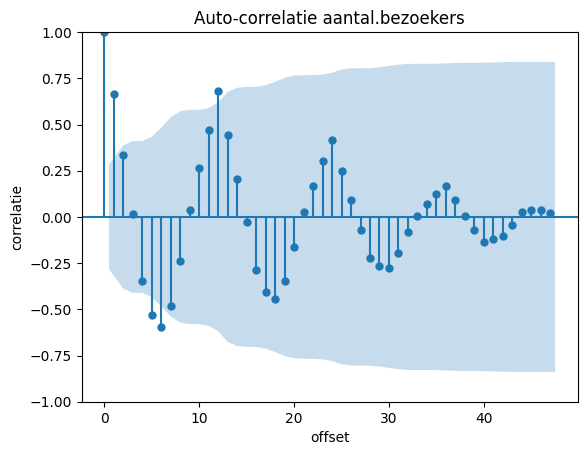

In [7]:
autocorrDia(df['aantal.bezoekers'])

print("Duidelijke piek om de twaalf maanden.")

4. Voer een trend estimation door en bepaal de slope en de intercept. Welke vergelijking vind je voor de trend?

In [8]:
model = GeneralRegression(degree=1)
model.fit(np.array([range(len(df['aantal.bezoekers']))]),df['aantal.bezoekers'])

print(model.intercept_)
print(model.coef_)

624.7712585034013
[ 0.         16.00086843]


5. Bereken de waarden van de trend voor het komende jaar. Welke waarden kom je uit?

In [9]:
voorspeldd = []
for i in range(len(df['aantal.bezoekers'])+1, len(df['aantal.bezoekers']) + 12+1):
    voorspeldd += [624.7712585034013 + i*16.00086843]

print(voorspeldd)

[1408.8138115734014, 1424.8146800034015, 1440.8155484334013, 1456.8164168634014, 1472.8172852934013, 1488.8181537234013, 1504.8190221534014, 1520.8198905834015, 1536.8207590134014, 1552.8216274434012, 1568.8224958734013, 1584.8233643034014]


7. Wat zijn de waarden van de seizoenscomponent?

0     0.185604
1     0.162009
2     0.806679
3     1.028785
4     2.045951
5     1.426356
6     2.526888
7     2.472179
8     0.737628
9     0.333068
10    0.185427
11    0.089425
12    0.185604
13    0.162009
14    0.806679
15    1.028785
16    2.045951
17    1.426356
18    2.526888
19    2.472179
20    0.737628
21    0.333068
22    0.185427
23    0.089425
24    0.185604
25    0.162009
26    0.806679
27    1.028785
28    2.045951
29    1.426356
30    2.526888
31    2.472179
32    0.737628
33    0.333068
34    0.185427
35    0.089425
36    0.185604
37    0.162009
38    0.806679
39    1.028785
40    2.045951
41    1.426356
42    2.526888
43    2.472179
44    0.737628
45    0.333068
46    0.185427
47    0.089425
Name: seasonal, dtype: float64


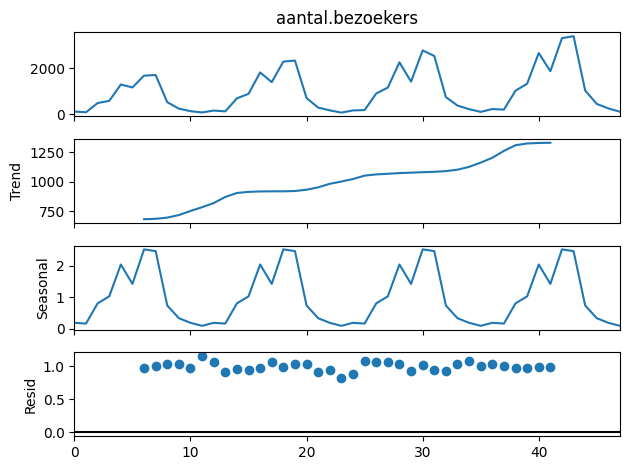

In [10]:
resultaat = seasonal_decompose(df['aantal.bezoekers'], model='multiplicatieve', period=12)
print(resultaat.seasonal)

resultaat.plot()
plt.show()